In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, det
from tqdm.notebook import tqdm
import random
from scipy.stats import multivariate_normal
import scipy
from numpy.linalg import eig

#**PCA**

$\tilde{x_n} = \sum_{i=0}^{M}z_{ni}u_i + \sum_{i=M+1}^{D}b_{i}u_i$

$z_{ni}$ works as the correlation between $x_n$ and $u_i$, determines the importance of $u_i$.

$b_i$ determines the center of the projected data.

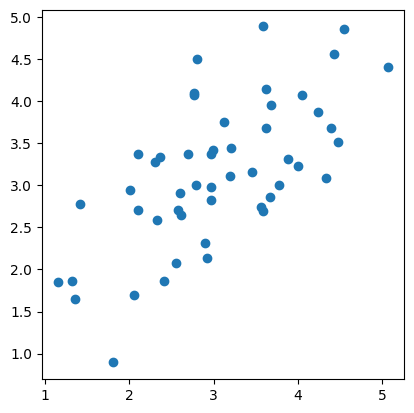

In [ ]:
data_size = 50

data = multivariate_normal.rvs([3, 3], [[1, 0.7], [0.7, 1]], data_size)

plt.scatter(data[:, 0], data[:, 1])
plt.gca().set_aspect('equal', adjustable='box')

[[0.85011176 0.52664401]
 [0.52664401 0.74807746]]
[0.2699853  1.32820392]
[[-0.67215295  0.74041232]
 [ 0.74041232  0.67215295]]


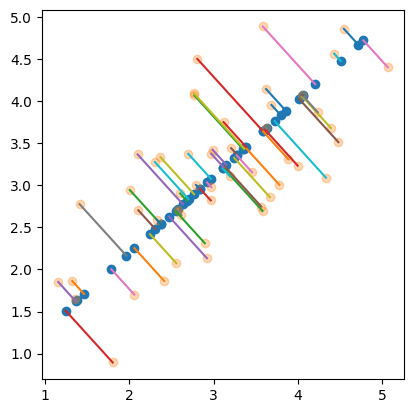

In [ ]:
from numpy.linalg import eig

mean = data.sum(axis=0, keepdims=True) / data_size
difference = data - mean
cov = (difference.T @ difference) / (data_size-1)
print(cov)
# cov = [[1, 0.7], [0.7, 1]]

eigvals, eigvects = eig(cov)
sort_indices = np.argsort(eigvals)
eigvals = eigvals[sort_indices]
eigvects = eigvects[:, sort_indices]
eigvects = eigvects.T
print(eigvals)
print(eigvects)

projected_data = []
bj = mean @ eigvects[0] # smaller eigenvalue
for n in range(0, data_size):
  znj = data[n].T @ eigvects[1] # bigger eigenvalue
  projected_data.append(eigvects[1] * znj + eigvects[0] * bj)
  plt.plot([projected_data[n][0], data[n][0]], [projected_data[n][1], data[n][1]])

projected_data = np.array(projected_data)
plt.scatter(projected_data[:, 0], projected_data[:, 1])
plt.scatter(data[:, 0], data[:, 1], alpha=0.3)

plt.gca().set_aspect('equal', adjustable='box')

#**PCA data compression**

11490434/11490434 [==============================] - 0s 0us/step
(6131, 28, 28)


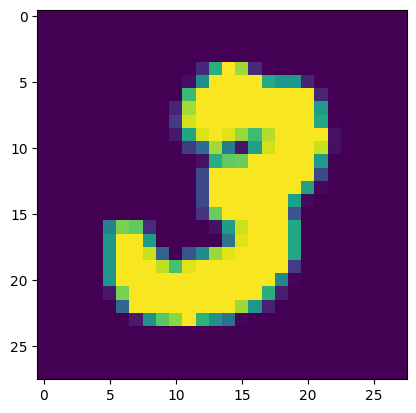

In [ ]:
from tensorflow.keras.datasets import mnist

data = mnist.load_data()
data = data[0]
data = data[0][data[1]==3]
print(data.shape)
plt.imshow(data[114])

(784, 784)


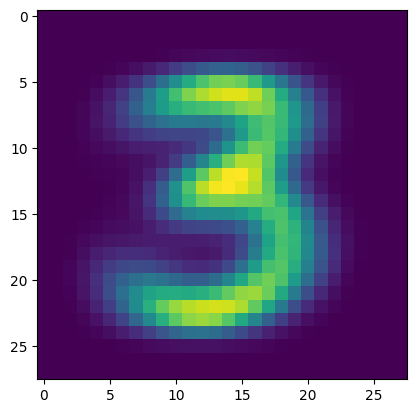

In [ ]:
N, _, _ = data.shape
data_ = data.reshape(N, -1)  # make it N * 784. Each image has 784 features
mean = data_.sum(axis=0, keepdims=True) / N
difference = data_ - mean
cov = (difference.T @ difference) / (N-1)
print(cov.shape)

eigvals, eigvects = eig(cov)
sort_indices = np.argsort(eigvals)
eigvals = eigvals[sort_indices]
eigvects = eigvects[:, sort_indices]
eigvects = eigvects.T
eigvects = eigvects.real  # it automatically adds a complex part even if it is 0
M = 4

# use 114th data as an example
xn = data_[114]
projected_xn = np.zeros_like(xn) * 1.0
for i in range(0, M):
  zni = xn.T @ eigvects[i]
  projected_xn += zni * eigvects[i].real

for i in range(M, 784):
  bi = mean @ eigvects[i]
  projected_xn += bi * eigvects[i]

projected_xn = projected_xn.reshape(28, 28)
plt.imshow(projected_xn)


#**PCA data preprocessing**

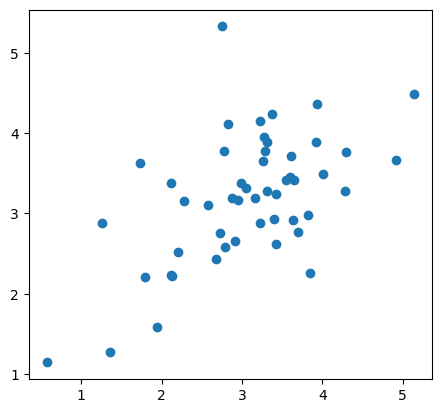

In [ ]:
data_size = 50
data = multivariate_normal.rvs([3, 3], [[1, 0.7], [0.7, 1]], data_size)
plt.scatter(data[:, 0], data[:, 1])
plt.gca().set_aspect('equal', adjustable='box')

[[0.79523168 0.40187581]
 [0.40187581 0.63669453]]
[-4.66293670e-17 -4.86277685e-16]
[[ 1.00000000e+00 -1.64597856e-16]
 [-1.64597856e-16  1.00000000e+00]]


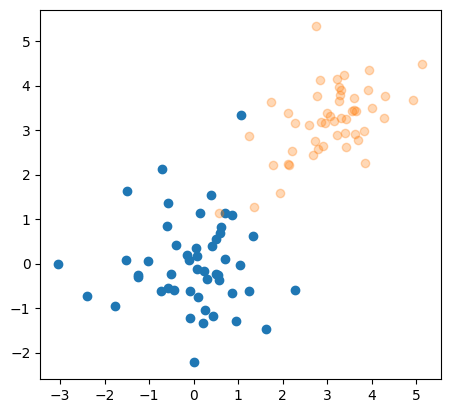

In [ ]:
from numpy.linalg import eig

mean = data.sum(axis=0, keepdims=True) / data_size
difference = data - mean
cov = (difference.T @ difference) / (data_size-1)
print(cov)
# cov = [[1, 0.7], [0.7, 1]]

eigvals, eigvects = eig(cov)
# print(eigvals)
# print(eigvects)

projected_data = np.zeros_like(data)


sqrt_L = np.diag(eigvals**(-0.5))
U = eigvects

for n in range(0, data_size):
  projected_data[n] = sqrt_L @ U.T @ (data[n] - mean[0])

projected_data = np.array(projected_data)
plt.scatter(projected_data[:, 0], projected_data[:, 1])
plt.scatter(data[:, 0], data[:, 1], alpha=0.3)


print(np.mean(projected_data, axis=0))
print(np.cov(projected_data, rowvar=False))

plt.gca().set_aspect('equal', adjustable='box')

#**Maximum likelihood PCA**

Define:
$$p(\mathbf{z}) = \mathcal{N}(\mathbf{z}|0, \mathbf{I})$$
$$p(\mathbf{x}|\mathbf{z}) = \mathcal{N}(\mathbf{x}|\mathbf{W}\mathbf{z}+\mu, \sigma^2\mathbf{I})$$

By (2.115) & (2.116), we get:
$$p(\mathbf{x}) = \mathcal{N}(\mathbf{x}|\mu, \mathbf{C})$$
$$p(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mathbf{x}|\mathbf{M}^{-1}\mathbf{W}^T(\mathbf{x}-\mu), \sigma^{2}\mathbf{M}^{-1})$$

where:
$$\mathbf{C} = \mathbf{W}\mathbf{W}^T + \sigma^2\mathbf{I}$$
$$\mathbf{M} = \mathbf{W}^T\mathbf{W} + \sigma^2\mathbf{I}$$
$$\mathbf{C}^{-1} = \sigma^{-2}\mathbf{I} + \sigma^{-2}\mathbf{W}\mathbf{M}^{-1}\mathbf{W}^T$$

By maximizing the log likelihood of $p(x)$, we get:
$$\mathbf{W}_{ML} = \mathbf{U}_M(\mathbf{L}_M - \sigma^2\mathbf{I})^{\frac{1}{2}}\mathbf{R}$$
$$\sigma^2_{ML} = \frac{1}{D-M} \sum_{i=M+1}^{D}\lambda_i$$

1. The summation of $\sigma^2_{ML}$ results in the additive property of variance.

2. When $D=M$, by substituting $\mathbf{W}_{ML}$, we get $\mathbf{C} = \mathbf{S}$

3. We've already obtained that $\mathbb{E}[\mathbf{z} | \mathbf{x}] = \mathbf{M}^{-1}\mathbf{W}^T(\mathbf{x}-\bar{\mathbf{x}})$. When $\sigma^2 = 0$ and suppose $\mathbf{R} = \mathbf{I}$, the posterior mean is $\mathbb{E}[\mathbf{z} | \mathbf{x}] = \mathbf{M}^{-1}\mathbf{W}^T(\mathbf{x}-\bar{\mathbf{x}}) = (\mathbf{W}^T\mathbf{W})^{-1}\mathbf{W}^T(\mathbf{x}-\bar{\mathbf{x}}) = ((\mathbf{U}_M\mathbf{L}_M^{\frac{1}{2}}\mathbf{R})^T\mathbf{U}_M\mathbf{L}_M^{\frac{1}{2}}\mathbf{R})^{-1}\mathbf{U}_M\mathbf{L}_M^{\frac{1}{2}}\mathbf{R}(\mathbf{x}-\bar{\mathbf{x}}) = \mathbf{L}_M^{-\frac{1}{2}}\mathbf{U}_M^T(\mathbf{x}-\bar{\mathbf{x}})$, which is a orthogonal projection.



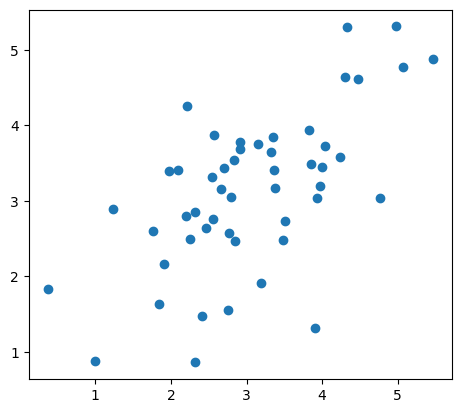

In [ ]:
data_size = 50
data = multivariate_normal.rvs([3, 3], [[1, 0.7], [0.7, 1]], data_size)
plt.scatter(data[:, 0], data[:, 1])
plt.gca().set_aspect('equal', adjustable='box')

[[2.5313085e-16]]


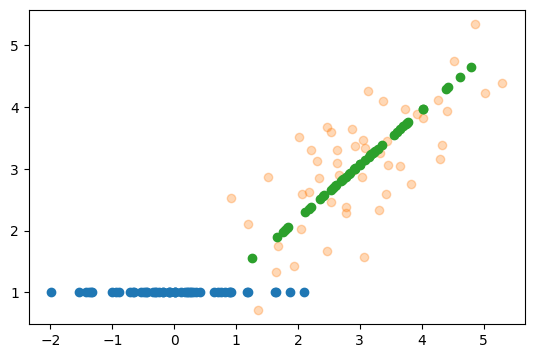

In [ ]:
from numpy.linalg import eig

mean = data.sum(axis=0, keepdims=True) / data_size
difference = data - mean
cov = (difference.T @ difference) / (data_size-1)

eigvals, eigvects = eig(cov)
sort_indices = np.argsort(eigvals)[::-1]
eigvals = eigvals[sort_indices]
eigvects = eigvects[:, sort_indices]

D = 2
M = 1
sigma_squared_ML = 1 / (D-M) * eigvals[M:].sum()
W_ML = eigvects[:, :M] @ (np.diag(eigvals[:M]) - np.eye(M) * sigma_squared_ML)**0.5 @ np.eye(M)
M_ML = (W_ML.T @ W_ML) + np.eye(M) * sigma_squared_ML


z = []
for n in range(0, data_size):
  z.append(inv(M_ML) @ W_ML.T @ (data[n] - mean).T)

# Plot latent variable
z = np.array(z)
plt.scatter(z[:, 0], np.ones((data_size,)))
plt.scatter(data[:, 0], data[:, 1], alpha=0.3)

# Plot recovered projected based on the posterior mean of x|z
projected_data = np.zeros_like(data)
for n in range(0, data_size):
  projected_data[n] = (W_ML @ z[n] + mean.T).T
plt.scatter(projected_data[:, 0], projected_data[:, 1])


print("mean", np.mean(z, axis=0))
print("variance", (z**2).sum() / data_size)

plt.gca().set_aspect('equal', adjustable='box')


Let's see what's gonna happen if we discard $\sigma^2$. As expected, we have the orthogonal projection.

[[2.55351296e-16]]
[[5.41824811e-37]
 [4.73764896e-37]]


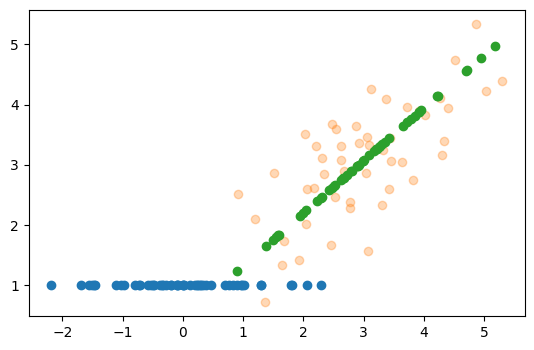

In [ ]:
from numpy.linalg import eig

mean = data.sum(axis=0, keepdims=True) / data_size
difference = data - mean
cov = (difference.T @ difference) / (data_size-1)

eigvals, eigvects = eig(cov)
sort_indices = np.argsort(eigvals)[::-1]
eigvals = eigvals[sort_indices]
eigvects = eigvects[:, sort_indices]

D = 2
M = 1
##########################################
sigma_squared_ML = 0
##########################################
W_ML = eigvects[:, :M] @ (np.diag(eigvals[:M]) - np.eye(M) * sigma_squared_ML)**0.5 @ np.eye(M)
M_ML = (W_ML.T @ W_ML) + np.eye(M) * sigma_squared_ML


z = []
for n in range(0, data_size):
  z.append(inv(M_ML) @ W_ML.T @ (data[n] - mean).T)

# Plot latent variable
z = np.array(z)
plt.scatter(z[:, 0], np.ones((data_size,)))
plt.scatter(data[:, 0], data[:, 1], alpha=0.3)

# Plot recovered projected based on the posterior mean of x|z
projected_data = np.zeros_like(data)
for n in range(0, data_size):
  projected_data[n] = (W_ML @ z[n] + mean.T).T
plt.scatter(projected_data[:, 0], projected_data[:, 1])


print("mean", np.mean(z, axis=0))
print("variance", (z**2).sum() / data_size)

plt.gca().set_aspect('equal', adjustable='box')

#Here's a test on 3D space

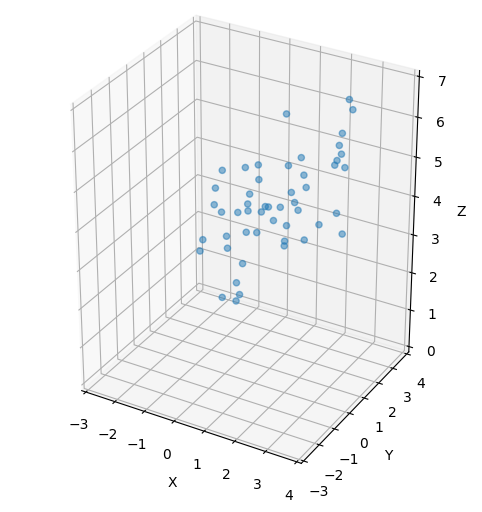

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

mean = [1, 1, 4]
covariance_matrix = np.array([[1, 0.8, 0.5],
                [0.8, 1, 0.3],
                [0.5, 0.3, 1]])

data_size = 50
data = np.random.multivariate_normal(mean, covariance_matrix, data_size)

def plotDatas(datas):
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')
  for data in datas:
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], marker='o', alpha=0.5)
  if (len(datas) == 2):
    for i in range(len(datas[0])):
      ax.plot([datas[0][i, 0], datas[1][i, 0]], [datas[0][i, 1], datas[1][i, 1]], [datas[0][i, 2], datas[1][i, 2]])
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')

  ax.set_xlim([-3, 4])  # Example x-axis limits
  ax.set_ylim([-3, 4])  # Example y-axis limits
  ax.set_zlim([0, 7])  # Example z-axis limits

  ax.set_box_aspect([np.ptp(data[:, 0]), np.ptp(data[:, 1]), np.ptp(data[:, 2])])
plotDatas([data])
plt.show()

(50, 2, 1)
mean [[-3.97459843e-16]
 [ 1.06692433e-15]]
variance 1.9599999999999997


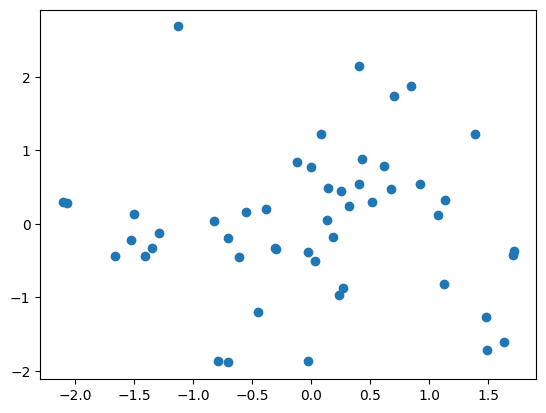

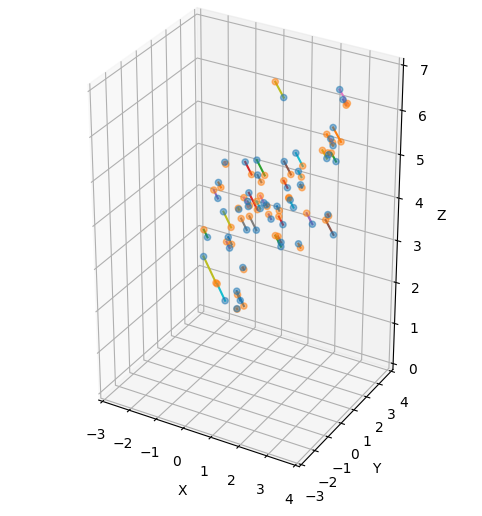

In [ ]:
from numpy.linalg import eig

mean = data.sum(axis=0, keepdims=True) / data_size
difference = data - mean
cov = (difference.T @ difference) / (data_size-1)

eigvals, eigvects = eig(cov)
sort_indices = np.argsort(eigvals)[::-1]
eigvals = eigvals[sort_indices]
eigvects = eigvects[:, sort_indices]

D = 3
M = 2
sigma_squared_ML = 0
W_ML = eigvects[:, :M] @ (np.diag(eigvals[:M]) - np.eye(M) * sigma_squared_ML)**0.5 @ np.eye(M)
M_ML = (W_ML.T @ W_ML) + np.eye(M) * sigma_squared_ML


z = []
for n in range(0, data_size):
  z.append(inv(M_ML) @ W_ML.T @ (data[n] - mean).T)

# Plot latent variable
z = np.array(z)

# Plot recovered projected based on the posterior mean of x|z
projected_data = np.zeros_like(data)
for n in range(0, data_size):
  projected_data[n] = (W_ML @ z[n] + mean.T).T
print("mean", np.mean(z, axis=0))
print("variance", (z**2).sum() / data_size)

plt.scatter(z[:, 0, 0], z[:, 1, 0])
plotDatas([data, projected_data])

#**EM algorithm for PCA**

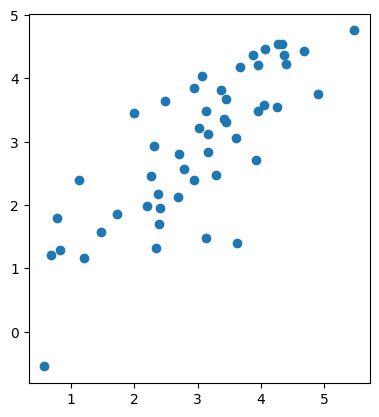

In [ ]:
data_size = 50
data = multivariate_normal.rvs([3, 3], [[1, 0.7], [0.7, 1]], data_size)
plt.scatter(data[:, 0], data[:, 1])
plt.gca().set_aspect('equal', adjustable='box')

E step:
$$\mathbb{E}[\mathbf{z}_n] = \mathbf{M}^{-1}\mathbf{W}^T(\mathbf{x}_n-\bar{\mathbf{x}})$$
$$\mathbb{E}[\mathbf{z}_n\mathbf{z}_n^T] = \sigma^2\mathbf{M}^{-1}+\mathbb{E}[\mathbf{z}_n]\mathbb{E}[\mathbf{z}_n]^T$$

M step:
$$\mathbf{W}_{new} = \Bigg[\sum_{n=1}^N(\mathbf{x}_n-\bar{\mathbf{x}})\mathbb{E}[\mathbf{z}_n]^T\Bigg]\Bigg[\sum_{n=1}^N\mathbb{E}[\mathbf{z}_n\mathbf{z}_n^T]\Bigg]^{-1}$$
$$\sigma^2_{new} = \frac{1}{ND}\sum_{n=1}^{N}\{ ||\mathbf{x}_n-\bar{\mathbf{x}}||^2 - 2\mathbb{E}[\mathbf{z}_n]^T\mathbf{W}_{new}^T(\mathbf{x}_n-\bar{\mathbf{x}}) + \mathbf{Tr}(\mathbb{E}[\mathbf{z}_n\mathbf{z}_n^T]\mathbf{W}_{new}^T\mathbf{W}_{new}) \}$$


mean [[1.11022302e-16]]
variance 1.013167006213039


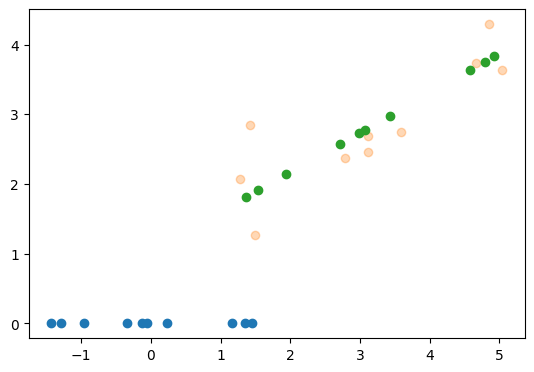

In [ ]:
from numpy.linalg import eig

mean = data.sum(axis=0, keepdims=True) / data_size

D = 2
M = 1
W = np.random.randn(D, M)
sigma_squared = 0.5
M_ = (W.T @ W) + np.eye(M) * sigma_squared


iters = 10
for iter in range(0, iters):
  # E
  Ez = []
  Ezz = []
  for n in range(0, data_size):
    Ez.append(inv(M_) @ W.T @ (data[n][np.newaxis, :] - mean).T)
    Ezz.append(sigma_squared * inv(M_) + Ez[n]@Ez[n].T)

  Ez = np.array(Ez)
  Ezz = np.array(Ezz)


  # M
  W = ((data - mean)[:, :, np.newaxis] * Ez.transpose(0, 2, 1)).sum(axis=0) @ (1 / Ezz.sum(axis=0))
  sigma_squared = 0
  for n in range(0, data_size):
    sigma_squared += ((data[n] - mean)**2).sum() - 2*Ez[n].T @ W.T @ (data[n]-mean).T + np.trace(Ezz[n].T @ W.T @ W)
  sigma_squared = sigma_squared / (data_size*D)
  M_ = (W.T @ W) + np.eye(M) * sigma_squared


z = []
for n in range(0, data_size):
  z.append(inv(M_) @ W.T @ (data[n] - mean).T)

# Plot latent variable
z = np.array(z)
plt.scatter(z[:, 0], np.zeros((data_size,)))
plt.scatter(data[:, 0], data[:, 1], alpha=0.3)

# Plot recovered projected based on the posterior mean of x|z
projected_data = np.zeros_like(data)
for n in range(0, data_size):
  projected_data[n] = (W @ z[n] + mean.T).T
plt.scatter(projected_data[:, 0], projected_data[:, 1])


print("mean", np.mean(z, axis=0))
print("variance", (z**2).sum() / data_size)

plt.gca().set_aspect('equal', adjustable='box')


We get orthogonal projection if we discard variance:

mean [[-2.33008057e-16]]
variance 0.14381553143057244


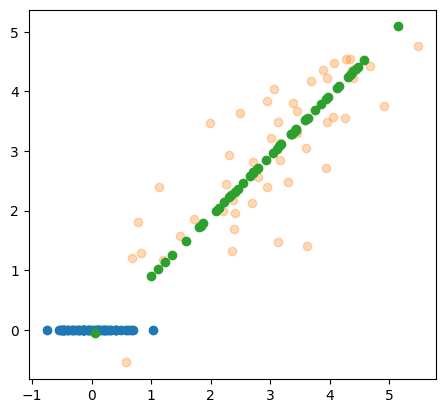

In [ ]:
from numpy.linalg import eig

mean = data.sum(axis=0, keepdims=True) / data_size

D = 2
M = 1
W = np.random.randn(D, M)
sigma_squared = 0


iters = 10
for iter in range(0, iters):
  # E
  Ez = []
  Ezz = []
  for n in range(0, data_size):
    Ez.append(inv(W.T @ W) @ W.T @ (data[n][np.newaxis, :] - mean).T)
    Ezz.append(Ez[n]@Ez[n].T)

  Ez = np.array(Ez)
  Ezz = np.array(Ezz)

  # M
  W = ((data - mean)[:, :, np.newaxis] * Ez.transpose(0, 2, 1)).sum(axis=0) @ (1 / Ezz.sum(axis=0))


z = []
for n in range(0, data_size):
  z.append(inv(W.T @ W) @ W.T @ (data[n] - mean).T)

# Plot latent variable
z = np.array(z)
plt.scatter(z[:, 0], np.zeros((data_size,)))
plt.scatter(data[:, 0], data[:, 1], alpha=0.3)

# Plot recovered projected based on the posterior mean of x|z
projected_data = np.zeros_like(data)
for n in range(0, data_size):
  projected_data[n] = (W @ z[n] + mean.T).T
plt.scatter(projected_data[:, 0], projected_data[:, 1])


print("mean", np.mean(z, axis=0))
print("variance", (z**2).sum() / data_size)

plt.gca().set_aspect('equal', adjustable='box')

# Visualize each step

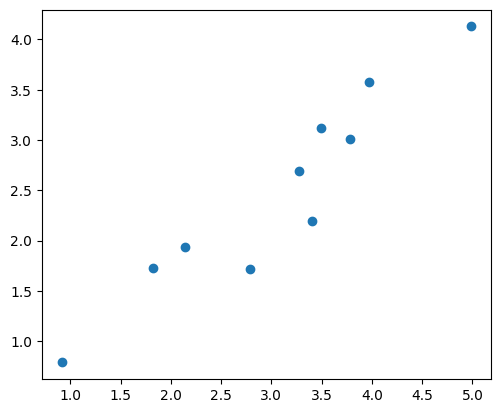

In [ ]:
data_size = 10
data = multivariate_normal.rvs([3, 3], [[1, 0.7], [0.7, 1]], data_size)
plt.scatter(data[:, 0], data[:, 1])
plt.gca().set_aspect('equal', adjustable='box')

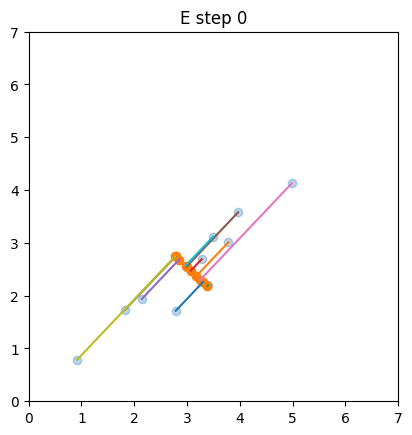

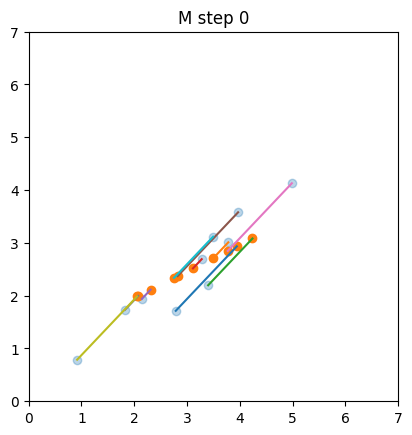

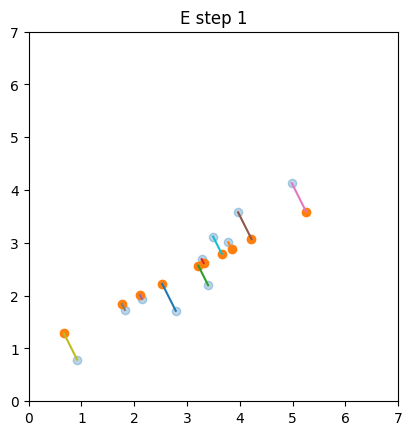

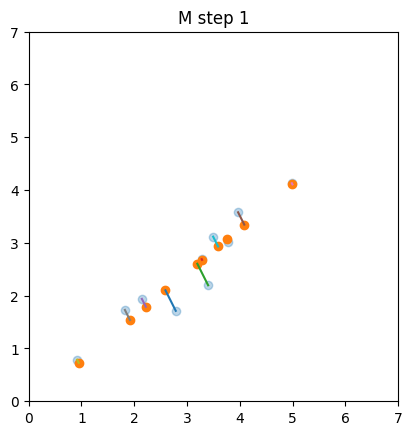

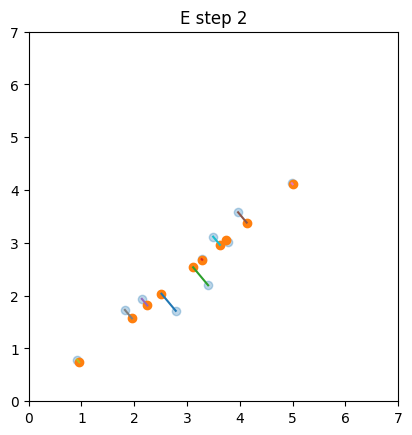

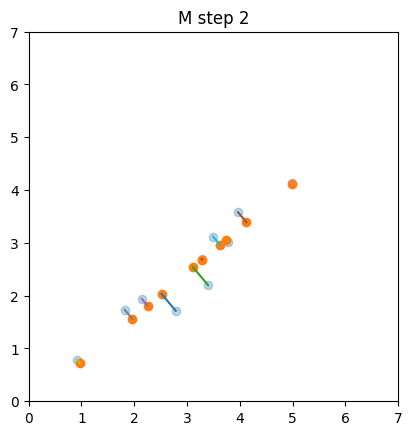

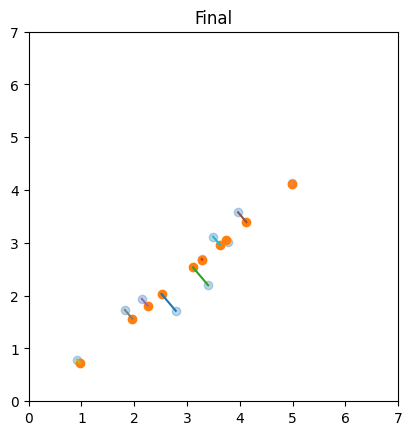

In [ ]:
from numpy.linalg import eig

mean = data.sum(axis=0, keepdims=True) / data_size

D = 2
M = 1
W = np.random.randn(D, M)
sigma_squared = 0


def PlotData(data, z, W):
  plt.scatter(data[:, 0], data[:, 1], alpha=0.3)
  projected_data = np.zeros_like(data)
  for n in range(0, data_size):
    projected_data[n] = (W @ z[n] + mean.T).T
  plt.scatter(projected_data[:, 0], projected_data[:, 1])
  for n in range(0, data_size):
    plt.plot([projected_data[n][0], data[n][0]], [projected_data[n][1], data[n][1]])


iters = 3
for iter in range(0, iters):
  # E step
  Ez = []
  Ezz = []
  for n in range(0, data_size):
    Ez.append(inv(W.T @ W) @ W.T @ (data[n][np.newaxis, :] - mean).T)
    Ezz.append(Ez[n]@Ez[n].T)

  Ez = np.array(Ez)
  Ezz = np.array(Ezz)

  # Plot data
  plt.figure(iter*2)
  plt.xlim(0, 7)
  plt.ylim(0, 7)
  plt.gca().set_aspect('equal', adjustable='box')
  PlotData(data, Ez, W)
  plt.title("E step " + str(iter))

  # M step
  W = ((data - mean)[:, :, np.newaxis] * Ez.transpose(0, 2, 1)).sum(axis=0) @ (1 / Ezz.sum(axis=0))

  # Plot data
  plt.figure(iter*2+1)
  plt.xlim(0, 7)
  plt.ylim(0, 7)
  plt.gca().set_aspect('equal', adjustable='box')
  PlotData(data, Ez, W)
  plt.title("M step " + str(iter))

z = []
for n in range(0, data_size):
  z.append(inv(W.T @ W) @ W.T @ (data[n] - mean).T)
z = np.array(z)
plt.figure(iters*2+1)
plt.title("Final")
plt.xlim(0, 7)
plt.ylim(0, 7)
plt.gca().set_aspect('equal', adjustable='box')
PlotData(data, z, W)

plt.gca().set_aspect('equal', adjustable='box')

# 3D

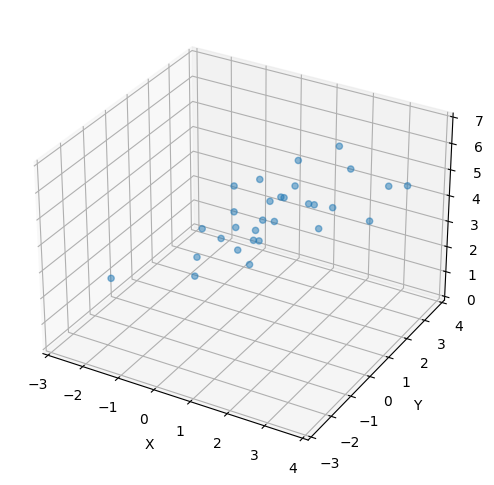

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

mean = [1, 1, 4]
covariance_matrix = np.array([[1, 0.8, 0.5],
                [0.8, 1, 0.3],
                [0.5, 0.3, 1]])

data_size = 30
data = np.random.multivariate_normal(mean, covariance_matrix, data_size)

def plotDatas(datas):
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')
  for data in datas:
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], marker='o', alpha=0.5)
  if (len(datas) == 2):
    for i in range(len(datas[0])):
      ax.plot([datas[0][i, 0], datas[1][i, 0]], [datas[0][i, 1], datas[1][i, 1]], [datas[0][i, 2], datas[1][i, 2]])
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')

  ax.set_xlim([-3, 4])  # Example x-axis limits
  ax.set_ylim([-3, 4])  # Example y-axis limits
  ax.set_zlim([0, 7])  # Example z-axis limits

  ax.set_box_aspect([np.ptp(data[:, 0]), np.ptp(data[:, 1]), np.ptp(data[:, 2])])
plotDatas([data])
plt.show()

mean [[-5.57424477e-16]
 [-9.62193288e-17]]
variance 1.234267915115279
[[ 0.25043722 -1.14794885]
 [ 0.30357138 -1.28917485]
 [ 1.57583885 -0.7553168 ]]


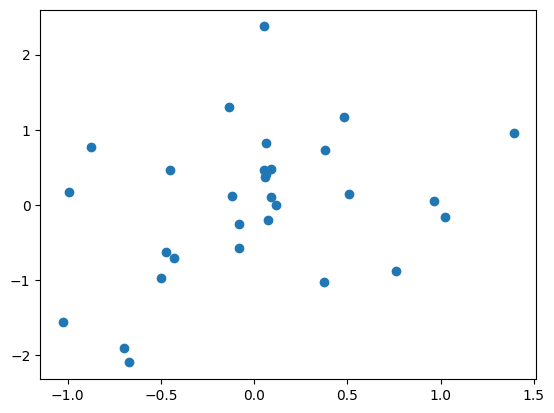

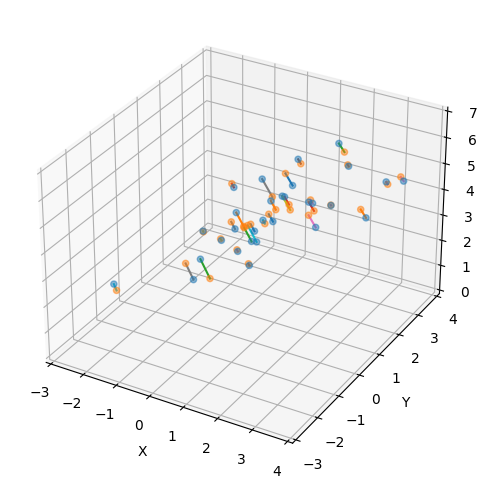

In [ ]:
from numpy.linalg import eig

mean = data.sum(axis=0, keepdims=True) / data_size

D = 3
M = 2
# W must be initialized properly so that its columns are linearly independent -> WTW is invertible
W = np.random.randn(D, M)
while np.linalg.matrix_rank(W) < min(3, 2):
  W = np.random.rand(3, 2)

sigma_squared = 0


iters = 10
for iter in range(0, iters):
  # E
  Ez = []
  Ezz = []
  for n in range(0, data_size):
    Ez.append(inv(W.T @ W) @ W.T @ (data[n] - mean).T)
    Ezz.append(Ez[n]@Ez[n].T)

  Ez = np.array(Ez)
  Ezz = np.array(Ezz)

  # M
  # W = ((data - mean)[:, :, np.newaxis] * Ez.transpose(0, 2, 1)).sum(axis=0) @ (1 / Ezz.sum(axis=0))
  X_tilde = data - mean
  Omega = inv(W.T @ W) @ W.T @ X_tilde.T
  W = X_tilde.T @ Omega.T @ inv(Omega @ Omega.T)  # 12.59


z = []
for n in range(0, data_size):
  z.append(inv(W.T @ W) @ W.T @ (data[n] - mean).T)

# Plot latent variable
z = np.array(z)

# Plot recovered projected based on the posterior mean of x|z
projected_data = np.zeros_like(data)
for n in range(0, data_size):
  projected_data[n] = (W @ z[n] + mean.T).T


print("mean", np.mean(z, axis=0))
print("variance", (z**2).sum() / data_size)

plt.scatter(z[:, 0, 0], z[:, 1, 0])
plotDatas([data, projected_data])

print(W)

#**Bayesian PCA**

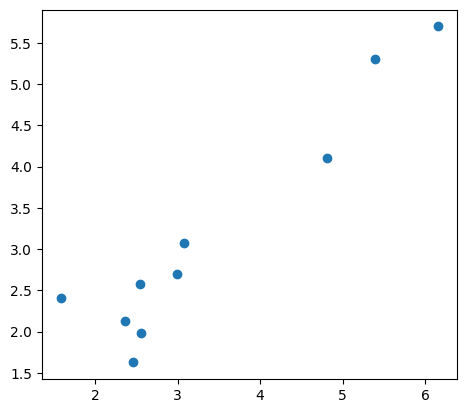

In [ ]:
data_size = 10
data = multivariate_normal.rvs([3, 3], [[1, 0.7], [0.7, 1]], data_size)
plt.scatter(data[:, 0], data[:, 1])
plt.gca().set_aspect('equal', adjustable='box')

mean [[-6.66133815e-17]]
variance 1.0706227852678194
[0.60645973]


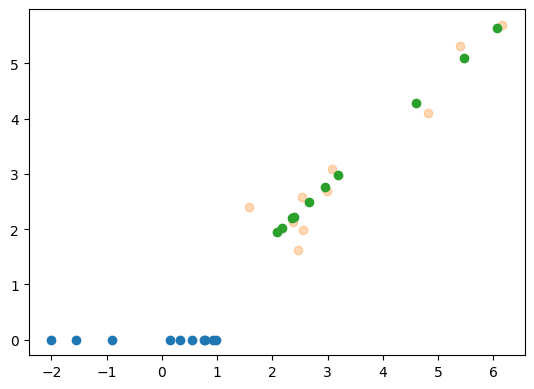

In [ ]:
from numpy.linalg import eig

mean = data.sum(axis=0, keepdims=True) / data_size

D = 2
M = 1
W = np.random.randn(D, M)
sigma_squared = 0.5
M_ = (W.T @ W) + np.eye(M) * sigma_squared
alpha = np.ones((M,)) * 0.1

iters = 10
for iter in range(0, iters):
  # E
  Ez = []
  Ezz = []
  for n in range(0, data_size):
    Ez.append(inv(M_) @ W.T @ (data[n][np.newaxis, :] - mean).T)
    Ezz.append(sigma_squared * inv(M_) + Ez[n]@Ez[n].T)

  Ez = np.array(Ez)
  Ezz = np.array(Ezz)


  # M
  W = ((data - mean)[:, :, np.newaxis] * Ez.transpose(0, 2, 1)).sum(axis=0) @ (1 / (Ezz.sum(axis=0) + sigma_squared * np.diag(alpha)))
  sigma_squared = 0
  for n in range(0, data_size):
    sigma_squared += ((data[n] - mean)**2).sum() - 2*Ez[n].T @ W.T @ (data[n]-mean).T + np.trace(Ezz[n].T @ W.T @ W)
  sigma_squared = sigma_squared / (data_size*D)
  M_ = (W.T @ W) + np.eye(M) * sigma_squared
  for i in range(M):
    w = W[:, i]
    alpha[i] = D / (w.T @ w)


z = []
for n in range(0, data_size):
  z.append(inv(M_) @ W.T @ (data[n] - mean).T)

# Plot latent variable
z = np.array(z)
plt.scatter(z[:, 0], np.zeros((data_size,)))
plt.scatter(data[:, 0], data[:, 1], alpha=0.3)

# Plot recovered projected based on the posterior mean of x|z
projected_data = np.zeros_like(data)
for n in range(0, data_size):
  projected_data[n] = (W @ z[n] + mean.T).T
plt.scatter(projected_data[:, 0], projected_data[:, 1])


print("mean", np.mean(z, axis=0))
print("variance", (z**2).sum() / data_size)

plt.gca().set_aspect('equal', adjustable='box')
print(alpha)

# 3D

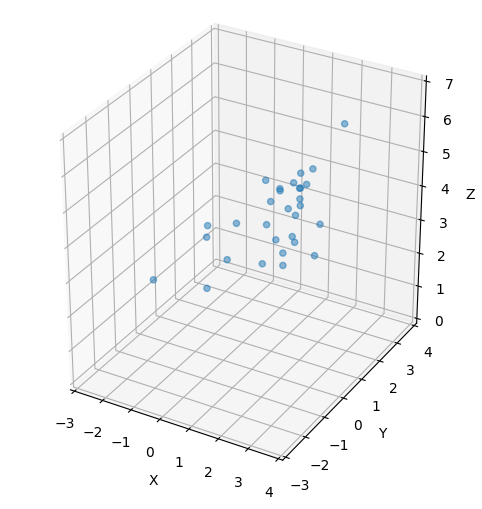

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

mean = [1, 1, 4]
covariance_matrix = np.array([[1, 0.8, 0.5],
                [0.8, 1, 0.3],
                [0.5, 0.3, 1]])

data_size = 30
data = np.random.multivariate_normal(mean, covariance_matrix, data_size)

def plotDatas(datas):
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')
  for data in datas:
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], marker='o', alpha=0.5)
  if (len(datas) == 2):
    for i in range(len(datas[0])):
      ax.plot([datas[0][i, 0], datas[1][i, 0]], [datas[0][i, 1], datas[1][i, 1]], [datas[0][i, 2], datas[1][i, 2]])
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')

  ax.set_xlim([-3, 4])  # Example x-axis limits
  ax.set_ylim([-3, 4])  # Example y-axis limits
  ax.set_zlim([0, 7])  # Example z-axis limits

  ax.set_box_aspect([np.ptp(data[:, 0]), np.ptp(data[:, 1]), np.ptp(data[:, 2])])
plotDatas([data])
plt.show()

mean [[-1.84536992e-15]
 [ 3.13313802e-04]]
variance 4.8055335619392135e+23
[[-9.30820240e-02 -3.46795594e-13]
 [-8.46030662e-02 -6.13527906e-13]
 [-9.08093415e-02  9.27071793e-13]]
[1.24645392e+02 2.21215155e+24]


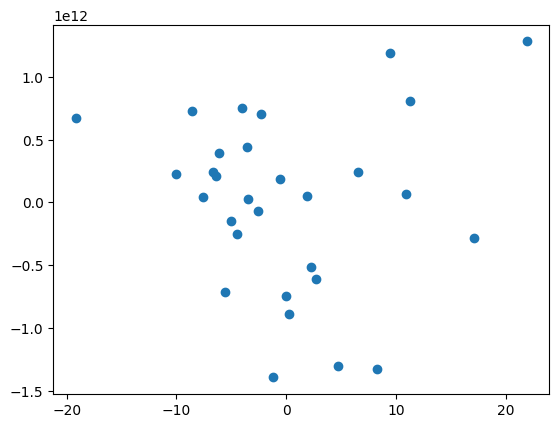

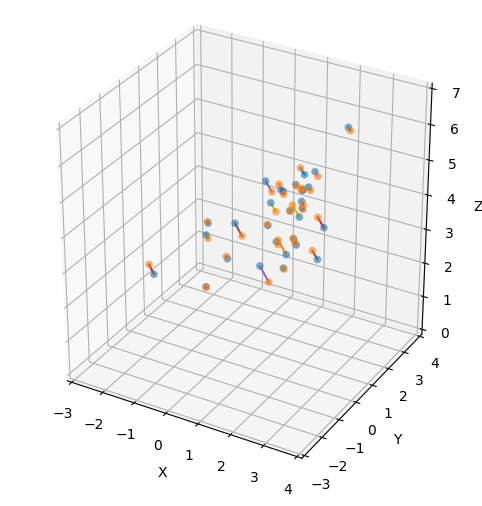

In [160]:
from numpy.linalg import eig

mean = data.sum(axis=0, keepdims=True) / data_size

N = data_size
D = 3
M = 2
# W must be initialized properly so that its columns are linearly independent -> WTW is invertible
W = np.random.randn(D, M)
while np.linalg.matrix_rank(W) < min(3, 2):
  W = np.random.rand(3, 2)
sigma_squared = 0.5
M_ = (W.T @ W) + np.eye(M) * sigma_squared
alpha = np.ones((M,)) * 0.1


iters = 100
for iter in range(0, iters):
  # E
  Ez = []
  Ezz = []
  for n in range(0, data_size):
    Ez.append(inv(M_) @ W.T @ (data[n] - mean).T)
    Ezz.append(sigma_squared * inv(M_) + Ez[n]@Ez[n].T)

  Ez = np.array(Ez)
  Ezz = np.array(Ezz)

  # M
  W = ((data - mean)[:, :, np.newaxis] * Ez.transpose(0, 2, 1)).sum(axis=0) @ (1 / (Ezz.sum(axis=0) + N * sigma_squared * np.diag(alpha)))
  sigma_squared = 0
  for n in range(0, data_size):
    sigma_squared += ((data[n] - mean)**2).sum() - 2*Ez[n].T @ W.T @ (data[n]-mean).T + np.trace(Ezz[n].T @ W.T @ W)
  sigma_squared = sigma_squared / (data_size*D)
  M_ = (W.T @ W) + np.eye(M) * sigma_squared
  for i in range(M):
    w = W[:, i]
    alpha[i] = D / (w.T @ w)


z = []
for n in range(0, data_size):
  z.append(inv(W.T @ W) @ W.T @ (data[n] - mean).T)
z = np.array(z)

# Plot recovered projected based on the posterior mean of x|z
projected_data = np.zeros_like(data)
for n in range(0, data_size):
  projected_data[n] = (W @ z[n] + mean.T).T


print("mean", np.mean(z, axis=0))
print("variance", (z**2).sum() / data_size)

plt.scatter(z[:, 0, 0], z[:, 1, 0])
plotDatas([data, projected_data])

print(W)
print(alpha)

#**Factor analysis**

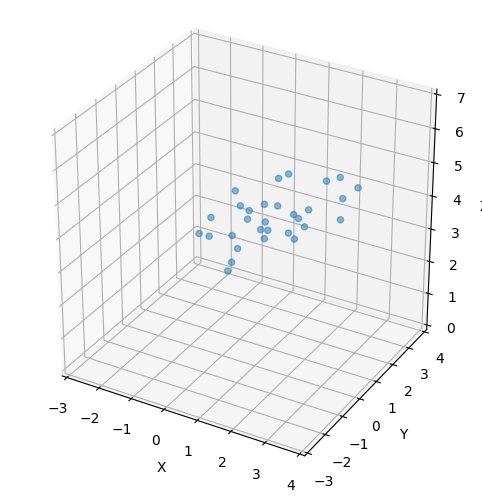

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

mean = [1, 1, 4]
covariance_matrix = np.array([[1, 0.8, 0.5],
                [0.8, 1, 0.3],
                [0.5, 0.3, 1]])

data_size = 30
data = np.random.multivariate_normal(mean, covariance_matrix, data_size)

def plotDatas(datas):
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')
  for data in datas:
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], marker='o', alpha=0.5)
  if (len(datas) == 2):
    for i in range(len(datas[0])):
      ax.plot([datas[0][i, 0], datas[1][i, 0]], [datas[0][i, 1], datas[1][i, 1]], [datas[0][i, 2], datas[1][i, 2]])
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')

  ax.set_xlim([-3, 4])  # Example x-axis limits
  ax.set_ylim([-3, 4])  # Example y-axis limits
  ax.set_zlim([0, 7])  # Example z-axis limits

  ax.set_box_aspect([np.ptp(data[:, 0]), np.ptp(data[:, 1]), np.ptp(data[:, 2])])
plotDatas([data])
plt.show()

[[0.90828039 0.70109294 0.59391437]
 [0.70109294 0.87454407 0.45354423]
 [0.59391437 0.45354423 0.97620704]]
mean [[-1.11792057e-13]
 [ 2.84217094e-13]]
variance 255911.86078842875
[[0.98928886 0.36431573]
 [0.87667175 0.32340087]
 [0.86571192 0.31737304]]


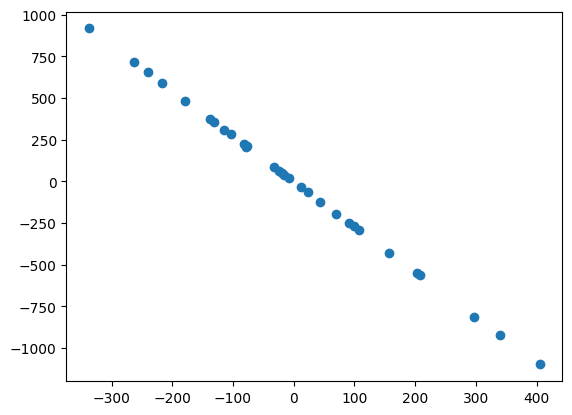

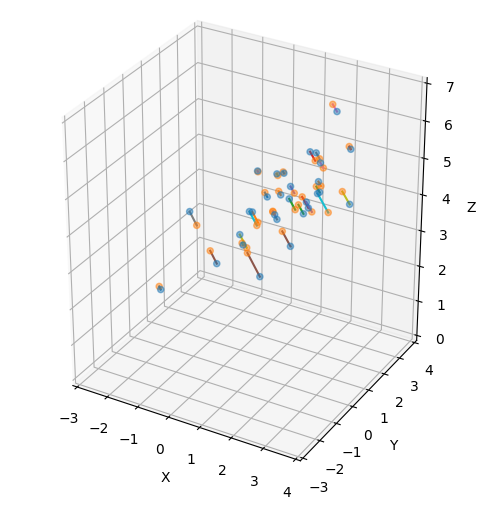

In [ ]:
from numpy.linalg import eig

mean = data.sum(axis=0, keepdims=True) / data_size
S = np.cov(data, rowvar = False)
print(S)

D = 3
M = 2
# W must be initialized properly so that its columns are linearly independent -> WTW is invertible
W = np.random.randn(D, M)
while np.linalg.matrix_rank(W) < min(3, 2):
  W = np.random.rand(3, 2)

Phi = np.diag([0.5] * D)


iters = 10
for iter in range(0, iters):
  # E
  Ez = []
  Ezz = []
  G = inv(np.eye(M) + W.T @ inv(Phi) @ W)
  for n in range(0, data_size):
    Ez.append(G @ W.T @ inv(Phi) @ (data[n] - mean).T)
    Ezz.append(G + Ez[n]@Ez[n].T)

  Ez = np.array(Ez)
  Ezz = np.array(Ezz)

  # M
  W = ((data - mean)[:, :, np.newaxis] * Ez.transpose(0, 2, 1)).sum(axis=0) @ (1 / Ezz.sum(axis=0))
  sum_ = np.zeros((2, 3))
  for n in range(0, N):
    sum_ += Ez[n] @ (data[n] - mean)
  Phi = np.eye(D) * (S - (W / N) @ sum_)


z = []
for n in range(0, data_size):
  z.append(inv(W.T @ W) @ W.T @ (data[n] - mean).T)

# Plot latent variable
z = np.array(z)

# Plot recovered projected based on the posterior mean of x|z
projected_data = np.zeros_like(data)
for n in range(0, data_size):
  projected_data[n] = (W @ z[n] + mean.T).T


print("mean", np.mean(z, axis=0))
print("variance", (z**2).sum() / data_size)

plt.scatter(z[:, 0, 0], z[:, 1, 0])
plotDatas([data, projected_data])

print(W)

#**Kernel PCA**

In [78]:
def LinearKernelFunction(phi1, phi2):
  # K. n * n
  if phi1.ndim == 2 and phi2.ndim == 2:
    return phi1 @ phi2.T
  # k. n,
  elif phi1.ndim == 1 and phi2.ndim == 2:
    return phi2 @ phi1
  elif phi1.ndim == 2 and phi2.ndim == 1:
    return phi1 @ phi2
  # k. 1,
  elif phi1.ndim == 1 and phi2.ndim == 1:
    return phi1 * phi2


def PolyKernelFunction(phi1, phi2):
  # K(x_, z_) = (γ * x_ @ z_ + r)**d
  d = 2.0,
  r = 1.0,
  γ = 1.0,
  K = LinearKernelFunction(phi1, phi2)
  K = (γ * K + r) ** d
  return K


def RBFKernelFunction(phi1, phi2):
  sigma = 1
  # K. n * n
  if phi1.ndim == 2 and phi2.ndim == 2:
    return np.exp(-1 / sigma**2 * ((phi1[:, np.newaxis, :] - phi2[np.newaxis, :, :])**2).sum(2))
  # k. n,
  elif phi1.ndim == 1 and phi2.ndim == 2:
    return np.exp(-1 / sigma**2 * ((phi2 - phi1[np.newaxis, :])**2).sum(1))
  elif phi1.ndim == 2 and phi2.ndim == 1:
    return np.exp(-1 / sigma**2 * ((phi1 - phi2[np.newaxis, :])**2).sum(1))
  # k. 1,
  elif phi1.ndim == 1 and phi2.ndim == 1:
    return np.exp(-1 / sigma**2 * ((phi1[np.newaxis, :] - phi2[np.newaxis, :])**2).sum(1))

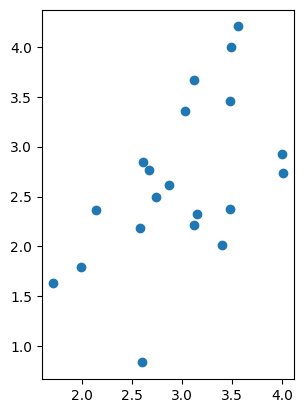

In [156]:
data_size = 20
data = multivariate_normal.rvs([3, 3], [[1, 0.7], [0.7, 1]], data_size)
plt.scatter(data[:, 0], data[:, 1])
plt.gca().set_aspect('equal', adjustable='box')

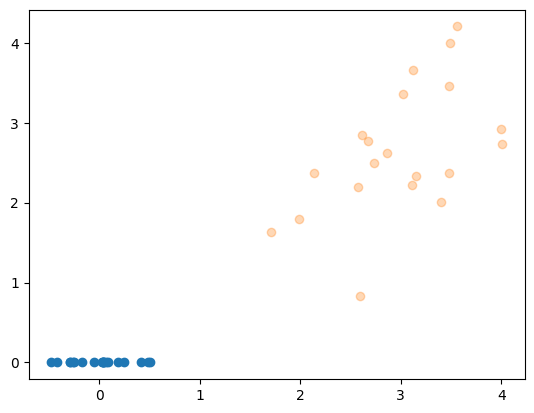

In [157]:
from numpy.linalg import eig

phi = data.sum(axis=1, keepdims=True)
K = LinearKernelFunction(phi, phi)
# K = RBFKernelFunction(phi, phi)
N1 = np.ones_like(K) / N
K = K - N1 @ K - K @ N1 + N1 @ K @ N1

N = data_size
D = 2
M = 1
eigvals, eigvects = eig(K)
sort_indices = np.argsort(eigvals)[::-1]
eigvals = eigvals[sort_indices].real
eigvects = eigvects[:, sort_indices].real

a = eigvects[:, :M]
# Normalize v
a = a / (eigvals[:M][:, np.newaxis] * N)**0.5
# print(eigvals[0] * N * a[:, 0].T @ a[:, 0])

y = np.zeros((data_size, M))
for n in range(0, data_size):
  k = K[:, n]
  for i in range(0, M):
    ai = a[:, i]
    y[n, i] = (ai * k).sum()


# Plot latent variable
plt.scatter(y[:, 0], np.zeros((data_size,)))
plt.scatter(data[:, 0], data[:, 1], alpha=0.3)